In [150]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [151]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pyarrow.parquet as pq
import scipy
from scipy import sparse as sp
import implicit
import re
import bisect
import sklearn.metrics as m
import catboost
from catboost import *
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModel

import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

In [153]:
print(catboost.__version__)
!python --version

1.0.6
Python 3.10.4


In [154]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'
COLUMNS_NO_URL = ['region_name','city_name','cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type','price','part_of_day','user_id']
CATEGORICAL_FEATURES=['region_name','city_name','cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type','part_of_day']

## Чтение данных

### id_to_submit

In [155]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [156]:
id_to_submit.head(2)

,user_id
221301,221301
31271,31271


In [157]:
id_to_submit.shape

(144724, 1)

### targets

In [158]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas()

In [159]:
targets.head(2)

,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276


### data

In [ ]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}').to_pandas()

In [ ]:
data.info()

In [ ]:
data.head(2)

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

## Предобработка данных

### Targets

#### age

In [160]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270000 entries, 350459 to 103148
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      269999 non-null  float64
 1   is_male  269958 non-null  object 
 2   user_id  270000 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ MB


In [161]:
targets.dropna(inplace=True)
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269957 entries, 350459 to 103148
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      269957 non-null  float64
 1   is_male  269957 non-null  object 
 2   user_id  269957 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ MB


**В задаче требуется определять возраст с 18 лет, понизим данное значение для первого баккета до 16 лет.**

In [162]:
def age_bucket(x):
    return bisect.bisect_left([1,25,35,45,55,65], x)

In [163]:
targets['age_target'] = targets['age'].map(age_bucket)

**Разбивка на группы по возрастам корректная**

In [164]:
targets['age_target'].value_counts()

2    87270
3    77486
4    42442
1    33647
5    23580
6     5503
0       29
Name: age_target, dtype: int64

In [165]:
targets = targets[targets['age_target'] != 0]

<AxesSubplot:>

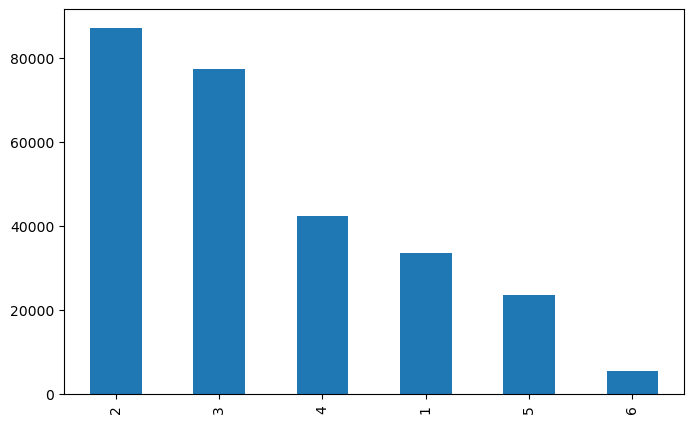

In [166]:
targets['age_target'].value_counts().plot(kind='bar',figsize=(8,5), alpha=1)

#### is_male

In [167]:
targets['is_male'].value_counts()

1     135314
0     128982
NA      5632
Name: is_male, dtype: int64

In [168]:
targets = targets[targets['is_male'] != 'NA']

In [169]:
targets['is_male'].value_counts()

1    135314
0    128982
Name: is_male, dtype: int64

**Много удалил NA!**

#### готовый target

In [170]:
targets = targets.astype('int')

In [171]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264296 entries, 350459 to 103148
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   age         264296 non-null  int32
 1   is_male     264296 non-null  int32
 2   user_id     264296 non-null  int32
 3   age_target  264296 non-null  int32
dtypes: int32(4)
memory usage: 6.0 MB


In [172]:
targets.head(2)

,age,is_male,user_id,age_target
350459,31,1,350459,2
188276,35,1,188276,2


### Data

### Создание признака день недели

In [ ]:
data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
data['day_of_week'] = data['day_of_week'].astype('str')

In [ ]:
data[['user_id','day_of_week','part_of_day']].to_parquet('data_day_of_week_part_of_day.pqt')

#### url_host only v.2

In [37]:
data_url_only = data[['user_id','url_host']]

In [38]:
def clip_domain(url):
    if url == None:
        return 'None'
    else:
        list_subdomain = url.split('.')
        if len(list_subdomain) > 3:
            return f'{list_subdomain[-4]}{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 3:
            return f'{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 2:
            return f'{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) < 2:
            return f'{list_subdomain[-1]}'

In [39]:
%%time
data_url_only['url_host'] = data_url_only['url_host'].apply(clip_domain)
data_url_only.to_parquet('data_url_only.pqt')

CPU times: total: 4min 30s
Wall time: 4min 30s


##### ПРИЗНАК текстовый на имени домана 2 уровня

In [39]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()

In [92]:
def creat_text(row):

    return " ".join(row)

In [93]:
%%time
feature_url_only_XX_2_domains_without_dot_text = data_url_only.groupby('user_id')['url_host'].agg(['unique'])
feature_url_only_XX_2_domains_without_dot_text['text_2_domains'] = feature_url_only_XX_2_domains_without_dot_text['unique'].apply(creat_text)
feature_url_only_XX_2_domains_without_dot_text.drop(columns = ['unique'], inplace=True)
feature_url_only_XX_2_domains_without_dot_text['user_id']=feature_url_only_XX_2_domains_without_dot_text.index
feature_url_only_XX_2_domains_without_dot_text.to_parquet('feature_url_only_XX_2_domains_without_dot_text_v2.pqt')

CPU times: total: 56.3 s
Wall time: 56.3 s


In [94]:
feature_url_only_XX_2_domains_without_dot_text

,text_2_domains,user_id
user_id,,
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1
2,lentarumediaeagleplatformcom iytimgcom node1on...,2
3,admailru avatarsmdsyandexnet mailyandexru pozd...,3
4,kpmd yastaticnet avatarsmdsyandexnet sun9-85us...,4
...,...,...
415312,googleadsgdoubleclicknet,415312
415313,avatarsmdsyandexnet,415313
415314,vkcom,415314


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для дней недели и времени дня

In [6]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [7]:
def creat_text(row):

    return " ".join(row)

In [8]:
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    for part_of_day in ['morning','day','evening','night']:
        data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
        data_temp.loc[(data_temp['day_of_week'] != day_of_week) | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
        feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
        feature[f'text_day_{day_of_week}_{part_of_day}'] = feature['unique'].apply(creat_text)
        feature.drop(columns = ['unique'], inplace=True)
        feature['user_id']=feature.index
        feature.to_parquet(f'feature_url_only_text_day_{day_of_week}_{part_of_day}.pqt')
        

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [42:16<00:00, 362.33s/it]


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для рабочих дней недели и времени дня

In [73]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [74]:
def creat_text(row):

    return " ".join(row)

In [75]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
    data_temp.loc[(data_temp['day_of_week'] == '5') | (data_temp['day_of_week'] == '6') | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_workday_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_workday_{part_of_day}.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:02<00:00, 120.75s/it]


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для выходных дней недели и времени дня

In [76]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [77]:
def creat_text(row):

    return " ".join(row)

In [78]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
    data_temp.loc[((data_temp['day_of_week'] != '5') & (data_temp['day_of_week'] != '6')) | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_weekend_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_weekend_{part_of_day}.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:49<00:00, 117.36s/it]


##### ПРИЗНАКИ текстовые на имени домена 2 уровня для времени дня

In [79]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [80]:
def creat_text(row):

    return " ".join(row)

In [81]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','part_of_day']]
    data_temp.loc[(data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_{part_of_day}.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:42<00:00, 85.53s/it]


##### ПРИЗНАКИ текстовые на имени домена 2 уровня для дней недели

In [82]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [83]:
def creat_text(row):

    return " ".join(row)

In [84]:
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
        data_temp = data[['user_id','url_host','day_of_week']]
        data_temp.loc[data_temp['day_of_week'] != day_of_week, 'url_host'] = ''
        feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
        feature[f'text_day_{day_of_week}'] = feature['unique'].apply(creat_text)
        feature.drop(columns = ['unique'], inplace=True)
        feature['user_id']=feature.index
        feature.to_parquet(f'feature_url_only_text_day_{day_of_week}.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:33<00:00, 81.90s/it]


#### ПРИЗНАК region_city

In [ ]:
feature_region_text = data[['user_id','region_name','city_name']]
#data.drop(['region_name','city_name'], axis=1, inplace=True)
feature_region_text = feature_region_text.groupby('user_id')['region_name','city_name'].agg(['unique'])
feature_region_text['region_text'] = ""

In [ ]:
# перевод в набор слов списка городов и регионов
def lemmatize_region(unique):

    text = ""
    for i in range(len(unique)):
        text +=unique[i]+' '
    return text

In [ ]:
for i in tqdm(feature_region_text.index):
    text = lemmatize_region(feature_region_text.loc[i,'region_name']['unique']) \
         + lemmatize_region(feature_region_text.loc[i,'city_name']['unique'])
    
    for word in ['область','Республика','край']:
        text = re.sub(word,'',text)
    feature_region_text['region_text'].loc[i] = text     


In [ ]:
feature_region_text = pd.DataFrame(feature_region_text['region_text']).reset_index()
feature_region_text.to_parquet('feature_region_text.pqt')

In [ ]:
feature_region_text.head(2)

#### ПРИЗНАК cpe_manufacturer_name,	cpe_model_name

In [ ]:
feature_manufacturer_model = data[['user_id','cpe_manufacturer_name','cpe_model_name']]
#data.drop(['cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type'], axis=1, inplace=True)
feature_manufacturer_model = feature_manufacturer_model.groupby('user_id')['cpe_manufacturer_name','cpe_model_name'].agg(['unique'])
feature_manufacturer_model = pd.DataFrame(feature_manufacturer_model.values).reset_index().rename(columns={'index':'user_id',0:'manufacturer',1:'model'})
for i in tqdm(feature_manufacturer_model.index):
    feature_manufacturer_model['manufacturer'][i] = feature_manufacturer_model['manufacturer'][i][0]
    feature_manufacturer_model['model'][i] = feature_manufacturer_model['model'][i][0]
feature_manufacturer_model.to_parquet('feature_manufacturer_model.pqt')
feature_manufacturer_model.head(2)

#### ПРИЗНАК cpe_type_cd,	cpe_model_os_type

In [ ]:
feature_cpe_os = data[['user_id','cpe_type_cd','cpe_model_os_type']]
#data.drop(['cpe_type_cd','cpe_model_os_type'], axis=1, inplace=True)
feature_cpe_os = feature_cpe_os.groupby('user_id')['cpe_type_cd','cpe_model_os_type'].agg(['unique'])
feature_cpe_os = pd.DataFrame(feature_cpe_os.values).reset_index().rename(columns={'index':'user_id',0:'cpe_type_cd',1:'cpe_model_os_type'})
for i in tqdm(feature_cpe_os.index):
    feature_cpe_os['cpe_type_cd'][i] = feature_cpe_os['cpe_type_cd'][i][0]
    feature_cpe_os['cpe_model_os_type'][i] = feature_cpe_os['cpe_model_os_type'][i][0]
feature_cpe_os.loc[feature_cpe_os['cpe_model_os_type'] == 'Apple iOS','cpe_model_os_type'] = 'iOS'
feature_cpe_os.to_parquet('feature_cpe_os.pqt')
feature_cpe_os.head(2)

#### ПРИЗНАК part_of_day

In [ ]:
feature_part_of_day = data[['user_id','part_of_day']]
#data.drop(['part_of_day'], axis=1, inplace=True)
feature_part_of_day = feature_part_of_day.groupby('user_id')['part_of_day'].agg(['sum'])

In [ ]:
def part_of_day_count(text):
    
        
    morning_count = text.count('morning')
    day_count = text.count('day')
    evening_count = text.count('evening')
    night_count = text.count('night')
    
    all_count = morning_count+day_count+evening_count+night_count
    
    morning_count_norm = morning_count/all_count
    day_count_norm = day_count/all_count
    evening_count_norm = evening_count/all_count
    night_count_norm = night_count/all_count  
    
    return (morning_count, 
            day_count, 
            evening_count, 
            night_count, 
            all_count, 
            morning_count_norm, 
            day_count_norm, 
            evening_count_norm, 
            night_count_norm)

In [ ]:
part_of_day_list = {'user_id': [], 
                    'morning_count': [], 
                    'day_count': [], 
                    'evening_count': [], 
                    'night_count': [], 
                    'all_count': [], 
                    'morning_count_norm': [], 
                    'day_count_norm': [], 
                    'evening_count_norm': [], 
                    'night_count_norm': []}

for i in tqdm(feature_part_of_day.index):
    part_of_day = part_of_day_count(feature_part_of_day.loc[i,'sum'])
    part_of_day_list['user_id'].append(i)
    part_of_day_list['morning_count'].append(part_of_day[0])
    part_of_day_list['day_count'].append(part_of_day[1])
    part_of_day_list['evening_count'].append(part_of_day[2])
    part_of_day_list['night_count'].append(part_of_day[3])
    part_of_day_list['all_count'].append(part_of_day[4])
    part_of_day_list['morning_count_norm'].append(part_of_day[5])
    part_of_day_list['day_count_norm'].append(part_of_day[6])
    part_of_day_list['evening_count_norm'].append(part_of_day[7])
    part_of_day_list['night_count_norm'].append(part_of_day[8])
    
    
feature_part_of_day = pd.DataFrame(data=part_of_day_list)
del part_of_day_list
feature_part_of_day.to_parquet('feature_part_of_day.pqt')

In [ ]:
feature_part_of_day.head(2)

#### ПРИЗНАК part_of_week

In [ ]:
feature_day_of_week = data[['user_id','day_of_week']]
#data.drop(['date'], axis=1, inplace=True)

In [ ]:
feature_day_of_week = feature_day_of_week.groupby('user_id')['day_of_week'].agg(['sum'])

In [ ]:
def day_of_week_count(text):
    
    day_0_count = text.count('0')
    day_1_count = text.count('1')
    day_2_count = text.count('2')
    day_3_count = text.count('3')
    day_4_count = text.count('4')
    day_5_count = text.count('5')
    day_6_count = text.count('6')
    
    day_all_count = day_0_count+day_1_count+day_2_count+day_3_count+day_4_count+day_5_count+day_6_count
    
    day_0_count_norm = day_0_count / day_all_count
    day_1_count_norm = day_1_count / day_all_count
    day_2_count_norm = day_2_count / day_all_count
    day_3_count_norm = day_3_count / day_all_count
    day_4_count_norm = day_4_count / day_all_count
    day_5_count_norm = day_5_count / day_all_count
    day_6_count_norm = day_6_count / day_all_count
    
    
    return (day_0_count, 
            day_1_count, 
            day_2_count, 
            day_3_count, 
            day_4_count, 
            day_5_count, 
            day_6_count, 
            day_all_count, 
            day_0_count_norm, 
            day_1_count_norm,
            day_2_count_norm, 
            day_3_count_norm, 
            day_4_count_norm, 
            day_5_count_norm, 
            day_6_count_norm)

In [ ]:
day_of_week_list = {
    'user_id': [], 
    'day_0_count': [],
    'day_1_count': [],
    'day_2_count': [],
    'day_3_count': [],
    'day_4_count': [],
    'day_5_count': [],
    'day_6_count': [],
    'day_all_count': [],
    'day_0_count_norm': [],
    'day_1_count_norm': [],
    'day_2_count_norm': [],
    'day_3_count_norm': [],
    'day_4_count_norm': [],
    'day_5_count_norm': [],
    'day_6_count_norm': [],
}

for i in tqdm(feature_day_of_week.index):
    day_of_week = day_of_week_count(feature_day_of_week.loc[i,'sum'])
    day_of_week_list['user_id'].append(i)
    day_of_week_list['day_0_count'].append(day_of_week[0])
    day_of_week_list['day_1_count'].append(day_of_week[1])
    day_of_week_list['day_2_count'].append(day_of_week[2])
    day_of_week_list['day_3_count'].append(day_of_week[3])
    day_of_week_list['day_4_count'].append(day_of_week[4])
    day_of_week_list['day_5_count'].append(day_of_week[5])
    day_of_week_list['day_6_count'].append(day_of_week[6])
    day_of_week_list['day_all_count'].append(day_of_week[7])
    day_of_week_list['day_0_count_norm'].append(day_of_week[8])
    day_of_week_list['day_1_count_norm'].append(day_of_week[9])
    day_of_week_list['day_2_count_norm'].append(day_of_week[10])
    day_of_week_list['day_3_count_norm'].append(day_of_week[11])
    day_of_week_list['day_4_count_norm'].append(day_of_week[12])
    day_of_week_list['day_5_count_norm'].append(day_of_week[13])
    day_of_week_list['day_6_count_norm'].append(day_of_week[14])
    
feature_day_of_week = pd.DataFrame(data=day_of_week_list)
del day_of_week_list
feature_day_of_week.to_parquet('feature_day_of_week.pqt')

In [ ]:
feature_day_of_week.head(2)

#### ПРИЗНАК price

In [ ]:
data_price = data[['user_id','price']]
#data.drop(['price'], axis=1, inplace=True)

In [ ]:
data_model = data[['user_id','cpe_model_name']]
data_model = data_model.groupby('user_id')['cpe_model_name'].agg(['unique'])

In [ ]:
feature_price = data_price.groupby('user_id')['price'].agg(['min','max','mean','std'])
user_not_price = feature_price[feature_price['min'].isna()].index.tolist()
model_name = data[['user_id','cpe_model_name']].query('user_id in @user_not_price')['cpe_model_name'].unique()

In [ ]:
feature_price.head()

In [ ]:
data_model_price_list = {
    'model':[],
    'price':[]
}
data_model_price = data[['cpe_model_name','price']]
for model in tqdm(model_name):
    data_model_price_list['model'].append(model)
    data_model_price_list['price'].append(data_model_price[data_model_price['cpe_model_name'] == model]['price'].mean())

In [ ]:
data_model_no_price = pd.DataFrame(data=data_model_price_list)
data_model_no_price.to_parquet('data_model_no_price.pqt')
data_model_no_price = pd.read_parquet(f'data_model_no_price.pqt')

In [ ]:
user_not_price_models = data_model.query('user_id in @user_not_price')
user_not_price_models['mean_price'] = np.nan

In [ ]:
user_not_price_models = pd.DataFrame(user_not_price_models.reset_index().values, columns=('user_id','model','model_price'))

In [ ]:
for i in tqdm(data_model_no_price.index):
    
    user_not_price_models.loc[user_not_price_models['model'] == data_model_no_price.loc[i,'model'], 'model_price'] = data_model_no_price.loc[i,'price']

In [ ]:
user_not_price_models.head()

In [ ]:
feature_price = feature_price.reset_index()

In [ ]:
feature_price.head()

In [ ]:
for i in tqdm(user_not_price_models.index):
    feature_price.loc[feature_price['user_id'] == user_not_price_models.loc[i,'user_id'],'min':'mean'] = user_not_price_models.loc[i,'model_price']

In [ ]:
feature_price.head()

##### Модель для заполнения пропусков стоимости телефона

объёдиним с признаком модель и производитель, а также регион

создадим таблицы трейн и предикт

In [ ]:
feature_manufacturer_model = pd.read_parquet(f'feature_manufacturer_model.pqt')
feature_region_text = pd.read_parquet(f'feature_region_text.pqt')

feature = pd.concat((feature_price,
                     feature_manufacturer_model.drop(['user_id'], axis=1),
                    ), axis=1)

text_features=None
cat_features = ['model','manufacturer']
embedding_features = None

feature_train = feature[~feature['mean'].isna()]
feature_predict = feature[feature['mean'].isna()]

pool_train = Pool(data=feature_train.drop(columns=['user_id','min','max','mean','std']), label=feature_train['mean'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_predict = Pool(data=feature_predict.drop(columns=['user_id','min','max','mean','std']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

In [ ]:
model_price = CatBoostRegressor(
    iterations=700,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='MAE',
    task_type = 'CPU',
    grow_policy='SymmetricTree',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_price",
    )
model_price.fit(
    pool_train,
    verbose=100,
    plot=True,
    )

In [ ]:
predict_price = model_price.predict(pool_predict)
feature_predict['min'] = predict_price
feature_predict['max'] = predict_price
feature_predict['mean'] = predict_price
feature_predict['std'] = 0

In [ ]:
feature_price = pd.concat((feature_train, feature_predict), axis=0).sort_index()[['user_id','min','max','mean']]
feature_price.to_parquet('feature_price.pqt')

#### ПРИЗНАК request_cnt

##### ПРИЗНАК feature_request_cnt_day_of_week_part_of_day

In [37]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    for part_of_day in ['morning','day','evening','night']:
        data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
        data_temp.loc[(data_temp['day_of_week'] != day_of_week) | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
        feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_day_{day_of_week}_{part_of_day}'})
        feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_day_of_week_part_of_day.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [22:46<00:00, 195.15s/it]


In [56]:
feature.head(2)

,text_morning,user_id,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,text_day_4,...,request_cnt_day_4_evening,request_cnt_day_4_night,request_cnt_day_5_morning,request_cnt_day_5_day,request_cnt_day_5_evening,request_cnt_day_5_night,request_cnt_day_6_morning,request_cnt_day_6_day,request_cnt_day_6_evening,request_cnt_day_6_night
0,googleadsgdoubleclicknet yastaticnet node1onl...,0,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,node1onlinesberbankru onlinesberbankru google...,...,1.000000,0.0,1.000000,1.000000,1.250,1.0,1.250000,4.000000,1.6000,0.0
1,iytimgcom linstagramcom googleadsgdoubleclick...,1,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,avatarsmdsyandexnet bannersadfoxru vkcom tass...,...,2.083333,1.0,1.297297,1.565217,1.375,1.0,1.411765,1.736842,1.3125,1.0


##### ПРИЗНАК feature_request_cnt_workday_part_of_day

In [57]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
    data_temp.loc[(data_temp['day_of_week'] == '5') | (data_temp['day_of_week'] == '6') | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_workday_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_workday_part_of_day.pqt')

##### ПРИЗНАК feature_request_cnt_weekend_part_of_day

In [58]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
    data_temp.loc[((data_temp['day_of_week'] != '5') & (data_temp['day_of_week'] != '6')) | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_weekend_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_weekend_part_of_day.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:20<00:00, 65.14s/it]


##### ПРИЗНАК feature_request_cnt_part_of_day

In [59]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','part_of_day']]
    data_temp.loc[(data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_part_of_day.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:01<00:00, 30.41s/it]


##### ПРИЗНАК feature_request_cnt_day_of_week

In [60]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week']]
    data_temp.loc[data_temp['day_of_week'] != day_of_week, 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_{day_of_week}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_day_of_week.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 29.15s/it]


#### url_host request_cnt

In [57]:
data_url_request_cnt = data[['user_id','url_host','request_cnt']]

In [58]:
data_url_request_cnt

,user_id,url_host,request_cnt
0,45098,ad.adriver.ru,1
1,45098,apple.com,1
2,45098,avatars.mds.yandex.net,1
3,45098,googleads.g.doubleclick.net,1
4,45098,googleads.g.doubleclick.net,1
...,...,...,...
322899430,300964,avatars.mds.yandex.net,1
322899431,300964,googleads.g.doubleclick.net,1
322899432,300964,online.sberbank.ru,1
322899433,300964,s0.2mdn.net,1


##### Обрезка домена второго уровня, без точки

In [59]:
def clip_domain(url):
    if url == None:
        return 'None'
    else:
        list_subdomain = url.split('.')
        if len(list_subdomain) > 3:
            return f'{list_subdomain[-4]}{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 3:
            return f'{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 2:
            return f'{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) < 2:
            return list_subdomain[-1]

In [60]:
%%time
data_url_request_cnt['url_host'] = data_url_request_cnt['url_host'].apply(clip_domain)

CPU times: total: 3min 48s
Wall time: 3min 48s


In [61]:
data_url_request_cnt.to_parquet('data_url_request_cnt_2domens.pqt')

In [62]:
data_url_request_cnt

,user_id,url_host,request_cnt
0,45098,adadriverru,1
1,45098,applecom,1
2,45098,avatarsmdsyandexnet,1
3,45098,googleadsgdoubleclicknet,1
4,45098,googleadsgdoubleclicknet,1
...,...,...,...
322899430,300964,avatarsmdsyandexnet,1
322899431,300964,googleadsgdoubleclicknet,1
322899432,300964,onlinesberbankru,1
322899433,300964,s02mdnnet,1


##### Sparce matrix url_cnt

In [33]:
data_url_request_cnt = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()

In [34]:
%%time
data_agg = data_url_request_cnt.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 45.9 s
Wall time: 46.1 s


In [35]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

198600 urls


In [36]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_cnt_sp_mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 2.25 s
Wall time: 2.31 s


In [37]:
url_cnt_sp_mat

<415317x198600 sparse matrix of type '<class 'numpy.int64'>'
	with 31690813 stored elements in COOrdinate format>

##### ПРИЗНАК url_cnt_sp_mat_als

In [38]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [39]:
als.fit(url_cnt_sp_mat)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)


In [40]:
feature_url_request_cnt_XX_2_domains_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_XX_2_domains_faiss_als['user_id'] = feature_url_request_cnt_XX_2_domains_faiss_als.index
feature_url_request_cnt_XX_2_domains_faiss_als.to_parquet(f'feature_url_request_cnt_XX_2_domains_faiss_als_{factors}.pqt')

##### ПРИЗНАК Sparce matrix url_cnt weekend

In [27]:
data_url_request_cnt_2domens = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()
day_of_week = data[['user_id','date']]
day_of_week['day_of_week'] = pd.to_datetime(day_of_week['date']).dt.dayofweek
url_request_cnt_2domens_weekend = pd.concat((data_url_request_cnt_2domens,
                                            day_of_week.drop(['user_id','date'], axis=1)
                                            ), axis=1)
url_request_cnt_2domens_weekend = url_request_cnt_2domens_weekend[(url_request_cnt_2domens_weekend['day_of_week']== 5) |
                                        (url_request_cnt_2domens_weekend['day_of_week']== 6)
                                       ]

In [28]:
%%time
data_agg = url_request_cnt_2domens_weekend.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 14 s
Wall time: 14 s


In [29]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

119616 urls


In [30]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_request_cnt_2domens_weekend = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 1.31 s
Wall time: 1.31 s


In [31]:
url_request_cnt_2domens_weekend

<415317x119616 sparse matrix of type '<class 'numpy.int64'>'
	with 16003173 stored elements in COOrdinate format>

In [32]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [33]:
als.fit(url_request_cnt_2domens_weekend)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)


In [34]:
feature_url_request_cnt_2domens_weekend_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_weekend_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_2domens_weekend_faiss_als['user_id'] = feature_url_request_cnt_2domens_weekend_faiss_als.index
feature_url_request_cnt_2domens_weekend_faiss_als.to_parquet(f'feature_url_request_cnt_2domens_weekend_faiss_als_{factors}.pqt')

##### ПРИЗНАК Sparce matrix url_cnt workday

In [35]:
data_url_request_cnt_2domens = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()
day_of_week = data[['user_id','date']]
day_of_week['day_of_week'] = pd.to_datetime(day_of_week['date']).dt.dayofweek
url_request_cnt_2domens_workday = pd.concat((data_url_request_cnt_2domens,
                                            day_of_week.drop(['user_id','date'], axis=1)
                                            ), axis=1)
url_request_cnt_2domens_workday = url_request_cnt_2domens_workday[(url_request_cnt_2domens_workday['day_of_week']== 0) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 1) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 2) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 3) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 4)
                                       ]

In [36]:
%%time
data_agg = url_request_cnt_2domens_workday.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 35.5 s
Wall time: 35.5 s


In [37]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

181994 urls


In [38]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_request_cnt_2domens_workday = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 2.94 s
Wall time: 2.94 s


In [39]:
url_request_cnt_2domens_workday

<415315x181994 sparse matrix of type '<class 'numpy.int64'>'
	with 27464636 stored elements in COOrdinate format>

In [40]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [41]:
als.fit(url_request_cnt_2domens_workday)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415315, 1200)


In [42]:
feature_url_request_cnt_2domens_workday_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_workday_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_2domens_workday_faiss_als['user_id'] = feature_url_request_cnt_2domens_workday_faiss_als.index
feature_url_request_cnt_2domens_workday_faiss_als.to_parquet(f'feature_url_request_cnt_2domens_workday_faiss_als_{factors}.pqt')

##### ПРИЗНАК текстовый на имени домана 2 уровня с учётом recuest_count

In [25]:
data_url_request_cnt = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()

In [26]:
%%time
data_url_request_cnt['url_cnt'] = (data_url_request_cnt['url_host']+' ') * data_url_request_cnt['request_cnt']

CPU times: total: 41.2 s
Wall time: 41.2 s


In [27]:
%%time
feature_url_request_cnt_XX_2_domains_without_dot_text = data_url_request_cnt.groupby('user_id')['url_cnt'].agg(['sum'])
feature_url_request_cnt_XX_2_domains_without_dot_text = pd.DataFrame(feature_url_request_cnt_XX_2_domains_without_dot_text['sum'].values, columns=['url_cnt'])
feature_url_request_cnt_XX_2_domains_without_dot_text['user_id']=feature_url_request_cnt_XX_2_domains_without_dot_text.index
feature_url_request_cnt_XX_2_domains_without_dot_text.to_parquet('feature_url_request_cnt_XX_2_domains_without_dot_text.pqt')

CPU times: total: 4min 31s
Wall time: 4min 32s


In [28]:
feature_url_request_cnt_XX_2_domains_without_dot_text

,url_cnt,user_id
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1
2,lentarumediaeagleplatformcom iytimgcom node1on...,2
3,admailru admailru avatarsmdsyandexnet avatarsm...,3
4,kpmd yastaticnet avatarsmdsyandexnet sun9-85us...,4
...,...,...
415312,googleadsgdoubleclicknet,415312
415313,avatarsmdsyandexnet,415313
415314,vkcom,415314
415315,yandexru,415315


##### ПРИЗНАК TF iDF векторайзер на 2_domains_without_dot

In [47]:
feature_url_request_cnt_XX_2_domains_without_dot_text = pq.read_table(f'feature_url_request_cnt_XX_2_domains_without_dot_text.pqt').to_pandas()

In [48]:
%%time
tfidf_vectorizer = TfidfVectorizer() # max_df=0.1 уменьшает качество
tfidf_text_2_domains = tfidf_vectorizer.fit_transform(feature_url_request_cnt_XX_2_domains_without_dot_text['url_cnt'])

CPU times: total: 5min 12s
Wall time: 5min 13s


In [49]:
%%time
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)
als.fit(tfidf_text_2_domains)
u_factors = als.model.user_factors 
print(u_factors.shape)
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als = pd.DataFrame(data=u_factors, columns=['tfidf_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als['user_id'] = feature_url_request_cnt_XX_2_domains_without_dot_text['user_id']
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.to_parquet('feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.pqt')

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)
CPU times: total: 17h 39min 47s
Wall time: 1h 33min 17s


In [50]:
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.head(2)

,tfidf_als_1,tfidf_als_2,tfidf_als_3,tfidf_als_4,tfidf_als_5,tfidf_als_6,tfidf_als_7,tfidf_als_8,tfidf_als_9,tfidf_als_10,...,tfidf_als_1192,tfidf_als_1193,tfidf_als_1194,tfidf_als_1195,tfidf_als_1196,tfidf_als_1197,tfidf_als_1198,tfidf_als_1199,tfidf_als_1200,user_id
0,-0.008092,0.005231,0.005598,0.000034,-0.005623,0.000086,-0.010248,0.000497,-0.003799,-0.010732,...,-0.023240,-0.004293,0.001847,-0.003774,-0.006201,0.005042,-0.004422,-0.004341,0.006276,0
1,-0.003669,-0.007651,0.008961,-0.007808,-0.000766,0.001027,0.002744,0.001519,-0.007577,-0.011865,...,0.010965,-0.011584,-0.011567,-0.000082,0.004702,0.009009,-0.007920,0.007937,0.006221,1


## Cosine (плохо)

Для каждого пользователя находим 30 наиболее похожих на него пользователя по urlam.

In [167]:
model_cosine = implicit.nearest_neighbours.CosineRecommender(K=30)
model_cosine.fit(url_cnt_sp_mat.tocsr().T)
model_cosine.save('model_cosine')

  0%|          | 0/415317 [00:00<?, ?it/s]

Для каждого пользователя из валид возьмём похожиш из трайн и определим пол по среднему, возраст по медиане(ошибка, нужно раскидывать по группам и брать группу с наибольшим количеством)?

In [250]:
user_id_list = list()
is_male_list = list()
age_list = list()

for user_id in tqdm(id_to_submit['user_id']): # перебираем всех юзеров из сабмит
    users_list = model_cosine.similar_items(user_id, N=30)[0]
    user_id_list.append(user_id)
    is_male_list.append(targets.query('user_id in @users_list')['is_male'].mean())
    age_list.append(targets.query('user_id in @users_list')['age_target'].value_counts().index[0])
id_to_submit = pd.DataFrame(np.array([user_id_list,is_male_list,age_list]).T, columns=['user_id','is_male','age'])
id_to_submit['user_id'] = id_to_submit['user_id'].astype('int')
id_to_submit['age'] = id_to_submit['age'].astype('int')

100%|██████████████████████████████████████████████████████████████████████████| 144724/144724 [25:59<00:00, 92.82it/s]


In [260]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)

## RESNET на эмбеддингах

In [50]:
BATCH_SIZE = 16384

### feature_url_only_XX_2_domains_tfidf_faiss_als_emb

In [51]:
feature_url_only_XX_2_domains_tfidf_faiss_als = pd.read_parquet(f'feature_url_request_cnt_XX_2_domains_faiss_als_1200.pqt')
# url_request_cnt - работает хуже чем url_only
#feature_url_only_XX_2_domains_tfidf_faiss_als = pd.read_parquet(f'feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.pqt')
print(feature_url_only_XX_2_domains_tfidf_faiss_als.shape)

(415317, 601)


#### DataLoader

#### split train,valid, submit

In [52]:
feature_target = targets.merge(feature_url_only_XX_2_domains_tfidf_faiss_als, how = 'inner', on = ['user_id'])
feature_submit = id_to_submit.merge(feature_url_only_XX_2_domains_tfidf_faiss_als, how = 'inner', on = ['user_id'])
print(feature_target.shape,
      feature_submit.shape)

feature_train, feature_val, label_train_is_male, label_val_is_male, label_train_age, label_val_age = train_test_split(\
    feature_target.drop(columns=['age','is_male','user_id','age_target']),\
    feature_target['is_male'], \
    feature_target['age_target'], test_size = 0.33, random_state = SPLIT_SEED)
print(feature_train.shape, feature_val.shape,label_train_is_male.shape,label_val_is_male.shape,label_train_age.shape,label_val_age.shape)

(264224, 604) (144724, 601)
(177030, 600) (87194, 600) (177030,) (87194,) (177030,) (87194,)


##### train

In [53]:
feature_train = feature_train.values
feature_train = np.moveaxis(feature_train[..., np.newaxis],1,2)
features_tensor = torch.tensor(feature_train.astype('float32'))
labels_is_male_tensor = torch.tensor(label_train_is_male.values).type(torch.LongTensor)
labels_age_tensor = torch.tensor(label_train_age.values).type(torch.LongTensor)

train = data_utils.TensorDataset(features_tensor, labels_is_male_tensor, labels_age_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

#del features, features_last_min_max, labels
del features_tensor, labels_is_male_tensor, labels_age_tensor

##### valid

In [54]:
feature_val = feature_val.values
feature_val = np.moveaxis(feature_val[..., np.newaxis],1,2)

features_val_tensor = torch.tensor(feature_val.astype('float32'))
labels_is_male_val_tensor = torch.tensor(label_val_is_male.values).type(torch.LongTensor)
labels_age_val_tensor = torch.tensor(label_val_age.values).type(torch.LongTensor)

valid = data_utils.TensorDataset(features_val_tensor, labels_is_male_val_tensor, labels_age_val_tensor)
valid_loader = data_utils.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

#del features, features_last_min_max, labels
del features_val_tensor, labels_is_male_val_tensor, labels_age_val_tensor

##### submit

In [55]:
features_submit_tensor = torch.tensor(feature_submit.drop(columns=['user_id']).values.astype('float32'))

submit = data_utils.TensorDataset(features_submit_tensor)
submit_loader = data_utils.DataLoader(submit, batch_size=BATCH_SIZE, shuffle=False)

#del feature_submit
del features_submit_tensor

In [56]:
dataset_iter = iter(submit_loader)
tensor = next(dataset_iter)[0]
tensor.shape

torch.Size([16384, 600])

#### ResNet

In [57]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels, inter_stride):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv1d(in_channels, inter_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(inter_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv1d(inter_channels, inter_channels, kernel_size=3, stride=inter_stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(inter_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv1d(inter_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(Downsample,self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    
class ResNet1D(nn.Module):
    def __init__(self):
        super(ResNet1D,self).__init__()
        
        # input
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=2, padding=3, bias=False) # kernel_size = 4 по умолчанию 7
        self.conv1 = nn.Conv1d(1, 128, kernel_size=600, stride=1, padding=0, bias=False) # kernel_size = 4 по умолчанию 7        
        self.bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # layer 1
        self.downsample_1 = Downsample(128, 256, 1)
        self.bottleneck_1_0 = Bottleneck(128, 64, 256, 1)
        self.bottleneck_1_1 = Bottleneck(256, 64, 256, 1)
        self.bottleneck_1_2 = Bottleneck(256, 64, 256, 1)
        
        # layer 2
        self.downsample_2 = Downsample(256, 512, 2) 
        self.bottleneck_2_0 = Bottleneck(256, 128, 512, 2)
        self.bottleneck_2_1 = Bottleneck(512, 128, 512, 1)
        self.bottleneck_2_2 = Bottleneck(512, 128, 512, 1)
        self.bottleneck_2_3 = Bottleneck(512, 128, 512, 1)
               
        # layer 3
        self.downsample_3 = Downsample(512, 1024, 2)
        self.bottleneck_3_0 = Bottleneck(512, 256, 1024, 2)
        self.bottleneck_3_1 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_2 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_3 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_4 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_5 = Bottleneck(1024, 256, 1024, 1)
                   
        # layer 4
        self.downsample_4 = Downsample(1024, 2048, 2)
        self.bottleneck_4_0 = Bottleneck(1024, 512, 2048, 2)
        self.bottleneck_4_1 = Bottleneck(2048, 512, 2048, 1)
        self.bottleneck_4_2 = Bottleneck(2048, 512, 2048, 1)
        
        # linear
        self.bn2 = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
        self.flatten = nn.Flatten()
        #self.linear1 = nn.Linear(in_features=2048, out_features=500, bias=True)
        self.linear1 = nn.Linear(in_features=2048, out_features=512, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(512, 128, bias=False)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear3 = nn.Linear(128, 7, bias=False)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x):
        # input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        # layer 1
        x_downsampled = self.downsample_1(x)
        x = self.bottleneck_1_0(x)
        x = self.bottleneck_1_1(x)
        x = self.bottleneck_1_2(x)
        x = x + x_downsampled
        # layer 2
        x_downsampled = self.downsample_2(x)
        x = self.bottleneck_2_0(x)
        x = self.bottleneck_2_1(x)
        x = self.bottleneck_2_2(x)
        x = self.bottleneck_2_3(x)
        x = x + x_downsampled        
        # layer 3
        x_downsampled = self.downsample_3(x)
        x = self.bottleneck_3_0(x)
        x = self.bottleneck_3_1(x)
        x = self.bottleneck_3_2(x)
        x = self.bottleneck_3_3(x)
        x = self.bottleneck_3_4(x)
        x = self.bottleneck_3_5(x)
        x = x + x_downsampled          
        # layer 4
        x_downsampled = self.downsample_4(x)
        x = self.bottleneck_4_0(x)
        x = self.bottleneck_4_1(x)
        x = self.bottleneck_4_2(x)
        x = x + x_downsampled        
        # linear
        #x_min_max = self.bn2(x_min_max)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.linear2(x)
        x = self.relu3(x)
        x = self.linear3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x    

#### Net train_age

In [ ]:
%%time

EPOCH=500

res_net = ResNet1D().to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_net.parameters(), lr=0.005)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, _, y_age_batch = batch
        X_batch = X_batch.to('cuda')
        y_age_batch = y_age_batch.to('cuda')
        
        output = res_net.forward(X_batch)
        loss =loss_fn(output, y_age_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
        
    if epoch % 1 == 0:
        
        print('---***---***---***---***---***---***---***---***---***---***---***---***---')
        print('Predict start')
        predict = torch.empty((1), dtype=torch.float).to('cuda')
        y_valid_tensor = torch.empty((1), dtype=torch.float)
        
#        res_net.eval()
        
        for i_valid, batch_valid in enumerate(valid_loader):
            X_batch_valid, _, y_age_batch_valid = batch_valid
            X_batch_valid = X_batch_valid.to('cuda')
            
            predict_batch = torch.argmax(res_net.inference(X_batch_valid), dim=1)
            predict = torch.cat((predict, predict_batch), 0)
            y_valid_tensor = torch.cat((y_valid_tensor, y_age_batch_valid), 0)
            
#         res_net.train()
        
        predict = predict[1:]
        y_valid_tensor = y_valid_tensor[1:]
        #epoch_list.append(epoch)
        loss_mean = loss_array.mean()
        #loss_list.append(loss_mean)
        print(f'Epoch: {epoch}, loss: {loss_mean:.3f}')
        predict = predict.to('cpu').detach().numpy()
        report = m.classification_report(y_valid_tensor.detach().numpy(), predict, output_dict=True)
        f1__weighted_avg = report['weighted avg']['f1-score']
        print('F1 weighted avg: ', f1__weighted_avg)


#### Net train_is_male

In [ ]:
%%time

EPOCH=500

res_net = ResNet1D().to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_net.parameters(), lr=0.005)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_is_male_batch, _ = batch
        X_batch = X_batch.to('cuda')
        y_is_male_batch = y_is_male_batch.to('cuda')
        
        output = res_net.forward(X_batch)
        loss =loss_fn(output, y_is_male_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
        
    if epoch % 1 == 0:
        
        print('---***---***---***---***---***---***---***---***---***---***---***---***---')
        print('Predict start')
        predict = np.empty((1), dtype=float)
        y_valid_tensor = np.empty((1), dtype=float)
        
        #res_net.eval()
        
        for i_valid, batch_valid in enumerate(valid_loader):
            X_batch_valid, y_is_male_batch_valid, _ = batch_valid
            X_batch_valid = X_batch_valid.to('cuda')

            predict_batch = res_net.inference(X_batch_valid)
            predict = np.concatenate((predict, predict_batch.to('cpu').detach().numpy()[:,1]), 0)
            y_valid_tensor = np.concatenate((y_valid_tensor, y_is_male_batch_valid.to('cpu').detach().numpy()), 0)
            
        #res_net.train()
        
        predict = predict[1:]
        y_valid_tensor = y_valid_tensor[1:]
        loss_mean = loss_array.mean()
        print(f'Epoch: {epoch}, loss: {loss_mean:.3f}')
        print(f'GINI по полу {2 * m.roc_auc_score(y_valid_tensor, predict) - 1:2.3f}')

## ИТОГОВАЯ СБОРКА DATA

### Чтение признаков из файлов

#### feature_url_only_text_day_of week_part_of_day

In [189]:
# Текст из уникальных доменов без точек
# разбивка по времени дня
# Дало прибавку к дефолту

feature_url_only_text_morning = pd.read_parquet(f'feature_url_only_text_morning.pqt')
feature_url_only_text_day = pd.read_parquet(f'feature_url_only_text_day.pqt')
feature_url_only_text_evening = pd.read_parquet(f'feature_url_only_text_evening.pqt')
feature_url_only_text_night = pd.read_parquet(f'feature_url_only_text_night.pqt')


feature_weekday_partday = pd.concat((
    feature_url_only_text_morning,
    feature_url_only_text_day.drop('user_id', axis=1),
    feature_url_only_text_evening.drop('user_id', axis=1),
    feature_url_only_text_night.drop('user_id', axis=1),
    ), axis=1)

del feature_url_only_text_morning, \
    feature_url_only_text_day, \
    feature_url_only_text_evening, \
    feature_url_only_text_night


text_features=['text_morning','text_day','text_evening','text_night']

In [190]:
feature_weekday_partday_mix = feature_weekday_partday
text_features_mix = text_features

In [191]:
# Текст из уникальных доменов без точек
# разбивка по дням недели
# Дало среднюю прибавку к дефолту

feature_url_only_text_day_0 = pd.read_parquet(f'feature_url_only_text_day_0.pqt')
feature_url_only_text_day_1 = pd.read_parquet(f'feature_url_only_text_day_1.pqt')
feature_url_only_text_day_2 = pd.read_parquet(f'feature_url_only_text_day_2.pqt')
feature_url_only_text_day_3 = pd.read_parquet(f'feature_url_only_text_day_3.pqt')
feature_url_only_text_day_4 = pd.read_parquet(f'feature_url_only_text_day_4.pqt')
feature_url_only_text_day_5 = pd.read_parquet(f'feature_url_only_text_day_5.pqt')
feature_url_only_text_day_6 = pd.read_parquet(f'feature_url_only_text_day_6.pqt')


feature_weekday_partday = pd.concat((
    feature_url_only_text_day_0,
    feature_url_only_text_day_1.drop('user_id', axis=1),
    feature_url_only_text_day_2.drop('user_id', axis=1),
    feature_url_only_text_day_3.drop('user_id', axis=1),
    feature_url_only_text_day_4.drop('user_id', axis=1),
    feature_url_only_text_day_5.drop('user_id', axis=1),
    feature_url_only_text_day_6.drop('user_id', axis=1),
    ), axis=1)

del feature_url_only_text_day_0, \
    feature_url_only_text_day_1, \
    feature_url_only_text_day_2, \
    feature_url_only_text_day_3, \
    feature_url_only_text_day_4, \
    feature_url_only_text_day_5, \
    feature_url_only_text_day_6

text_features=['text_day_0','text_day_1','text_day_2','text_day_3','text_day_4','text_day_5','text_day_6']

In [192]:
feature_weekday_partday_mix = pd.concat((
    feature_weekday_partday_mix,
    feature_weekday_partday.drop('user_id', axis=1),
    ), axis=1)

text_features_mix = text_features_mix + text_features

feature_weekday_partday = feature_weekday_partday_mix
text_features = text_features_mix

In [193]:
feature_weekday_partday

,text_morning,user_id,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,text_day_4,text_day_5,text_day_6
user_id,,,,,,,,,,,,
0,googleadsgdoubleclicknet yastaticnet node1onl...,0,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,node1onlinesberbankru onlinesberbankru google...,s02mdnnet googleadsgdoubleclicknet gotovim-do...,edaru googleadsgdoubleclicknet wildberriesru ...
1,iytimgcom linstagramcom googleadsgdoubleclick...,1,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,avatarsmdsyandexnet bannersadfoxru vkcom tass...,iytimgcom tpcgooglesyndicationcom trendsrbcru...,yandexru ipinimgcom s3amazonawscom allshopsme...
2,googleadsgdoubleclicknet yandexru vkcom node1...,2,lentarumediaeagleplatformcom yandexru iytimgc...,iytimgcom node1onlinesberbankru vkcom googlea...,googleadsgdoubleclicknet vkcom,iytimgcom googleadsgdoubleclicknet vkcom node...,googleadsgdoubleclicknet sun9-32userapicom ya...,lentarumediaeagleplatformcom yandexru googlea...,node1onlinesberbankru googleadsgdoubleclickne...,googleadsgdoubleclicknet tpcgooglesyndication...,iytimgcom googleadsgdoubleclicknet vkcom avat...,iytimgcom vkcom yandexru onlinesberbankru nod...
3,mailyandexru mvkcom yastaticnet admailru imas...,3,avatarsmdsyandexnet pozdravokru onlinesberban...,admailru onlinesberbankru zenyandexru relapio...,vkcom,vkcom sun9-17userapicom sun9-61userapicom onl...,admailru onlinesberbankru yandexru mailyandex...,onlinesberbankru relapio sun9-27userapicom av...,admailru imasdkgoogleapiscom adsbetweendigita...,avatarsmdsyandexnet zenyandexru mvkcom online...,mailyandexru yastaticnet awayvkcom admailru m...,admailru pozdravokru onlinesberbankru avatars...
4,kpmd yhbpotm-rcom s02mdnnet iytimgcom admailr...,4,avatarsmdsyandexnet adsbetweendigitalcom adsa...,yastaticnet sun9-85userapicom iytimgcom mvkco...,cloudmailru iytimgcom o2mailru,sun9-88userapicom iytimgcom enigma-projectru ...,adsadfoxru googlecom yandexru googleadsgdoubl...,avatarsmdsyandexnet adsadfoxru mvkcom stcallk...,adadriverru mvkcom cloudmailru imasdkgoogleap...,kpmd yastaticnet iytimgcom admailru prodoctor...,sun9-85userapicom yhbpotm-rcom iytimgcom vkco...,adsbetweendigitalcom s02mdnnet googleadsgdoub...
...,...,...,...,...,...,...,...,...,...,...,...,...
415312,,415312,googleadsgdoubleclicknet,,,,,,googleadsgdoubleclicknet,,,
415313,,415313,avatarsmdsyandexnet,,,,,,,,avatarsmdsyandexnet,
415314,,415314,vkcom,,,vkcom,,,,,,


In [194]:
text_features

['text_morning',
 'text_day',
 'text_evening',
 'text_night',
 'text_day_0',
 'text_day_1',
 'text_day_2',
 'text_day_3',
 'text_day_4',
 'text_day_5',
 'text_day_6']

#### feature_recuest_cnt_day_of_week_part_of_day

In [195]:
feature_request_cnt_day_of_week_part_of_day = pd.read_parquet(f'feature_request_cnt_day_of_week_part_of_day.pqt')
print(feature_request_cnt_day_of_week_part_of_day.shape)

(415317, 29)


In [196]:
feature_request_cnt_workday_part_of_day = pd.read_parquet(f'feature_request_cnt_workday_part_of_day.pqt')
print(feature_request_cnt_workday_part_of_day.shape)

(415317, 5)


In [197]:
feature_request_cnt_weekend_part_of_day = pd.read_parquet(f'feature_request_cnt_weekend_part_of_day.pqt')
print(feature_request_cnt_weekend_part_of_day.shape)

(415317, 5)


In [198]:
feature_request_cnt_part_of_day = pd.read_parquet(f'feature_request_cnt_part_of_day.pqt')
print(feature_request_cnt_part_of_day.shape)

(415317, 5)


In [199]:
#
#

feature_request_cnt_day_of_week = pd.read_parquet(f'feature_request_cnt_day_of_week.pqt')
print(feature_request_cnt_day_of_week.shape)

(415317, 8)


In [200]:
feature_request_cnt_weekday_partday = feature_request_cnt_day_of_week_part_of_day

#### Остальное

In [201]:
# Текст из уникальных доменов 2-го уровня без точек
feature_url_only_XX_2_domains_without_dot_text = pd.read_parquet(f'feature_url_only_XX_2_domains_without_dot_text.pqt')
print(feature_url_only_XX_2_domains_without_dot_text.shape)

# Текст регионы и города
feature_region_text = pd.read_parquet(f'feature_region_text.pqt')
print(feature_region_text.shape)

# Категориальные признаки производитель и модель устройства
feature_manufacturer_model = pd.read_parquet(f'feature_manufacturer_model.pqt')
print(feature_manufacturer_model.shape)

# Категориальные признаки тип устройства и тип ос
feature_cpe_os = pd.read_parquet(f'feature_cpe_os.pqt')[['user_id','cpe_model_os_type']]
print(feature_cpe_os.shape)

# Числовой признак часть суток, несколько столбцов (счётный и нормализованный для всех частей суток)
feature_part_of_day = pd.read_parquet(f'feature_part_of_day.pqt')
feature_part_of_day = feature_part_of_day[['user_id','morning_count','day_count','evening_count','night_count']]
#feature_part_of_day = feature_part_of_day[['user_id','morning_count_norm','day_count_norm','evening_count_norm','night_count_norm']]
print(feature_part_of_day.shape)

# Числовой признак день недели, несколько столбцов (счётный и нормализованный для всех дней недели)
feature_day_of_week = pd.read_parquet(f'feature_day_of_week.pqt')
feature_day_of_week = feature_day_of_week[['user_id','day_0_count','day_1_count','day_2_count','day_3_count','day_4_count','day_5_count','day_6_count']]
print(feature_day_of_week.shape)

# Числовой признак цена устройства
feature_price = pd.read_parquet(f'feature_price.pqt')
print(feature_price.shape)


feature = pd.concat((feature_url_only_XX_2_domains_without_dot_text,
                     feature_weekday_partday.drop('user_id', axis=1),
                     #feature_url_request_cnt_XX_2_domains_without_dot_text,
                     #feature_url_only_XX_2_domains_clean_description_text.drop('user_id', axis=1),
                     #feature_url_only_XX_2_domains_tfidf_faiss_als.drop('user_id', axis=1),
                     #feature_url_only_XX_2_domains_tfidf_faiss_als_emb.drop('user_id', axis=1),
                     #feature_description_only_XX_2_domains_clean_text_emb.drop('user_id', axis=1),
                     #feature_description_only_XX_2_domains_clean_text_separate_emb.drop('user_id', axis=1),
                     feature_region_text.drop('user_id', axis=1),
                     feature_manufacturer_model.drop('user_id', axis=1),
                     feature_part_of_day.drop('user_id', axis=1),
                     #feature_day_of_week.drop('user_id', axis=1),
                     feature_price.drop(['user_id','min','max'], axis=1),
                     feature_cpe_os.drop(['user_id'], axis=1),
                     feature_request_cnt_weekday_partday.drop('user_id', axis=1),
                     #feature_url_request_cnt_XX_2_domains_faiss_als_1200.drop('user_id', axis=1),
                     #feature_url_request_cnt_2domens_weekend_faiss_als.drop('user_id', axis=1),
                     #feature_url_request_cnt_2domens_workday_faiss_als.drop('user_id', axis=1),
                    ), axis=1)
print(feature.shape)

#feature = feature_url_request_cnt_2domens_weekend_faiss_als

#embedding_features=['domains_2_tfidf_faiss_als_emb','description_bert_emb']
#embedding_features=['description_bert_emb']
embedding_features=None
#text_features=['text_2_domains','description_text_2_domains','region_text','url_cnt']
#text_features=['text_2_domains','region_text']
#text_features=['text_day_0_day','region_text']
text_features += ['text_2_domains','region_text']

#text_features=None
cat_features = ['manufacturer','model','cpe_model_os_type']
#cat_features = ['manufacturer','model']
#cat_features = None

del feature_url_only_XX_2_domains_without_dot_text, \
    feature_region_text, \
    feature_manufacturer_model, \
    feature_part_of_day, \
    feature_day_of_week, \
    feature_price, \
    feature_cpe_os, \
    feature_request_cnt_weekday_partday

(415317, 2)
(415317, 2)
(415317, 3)
(415317, 2)
(415317, 5)
(415317, 8)
(415317, 4)
(415317, 50)


In [202]:
feature.head(2)

,text_2_domains,user_id,text_morning,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,...,request_cnt_day_4_evening,request_cnt_day_4_night,request_cnt_day_5_morning,request_cnt_day_5_day,request_cnt_day_5_evening,request_cnt_day_5_night,request_cnt_day_6_morning,request_cnt_day_6_day,request_cnt_day_6_evening,request_cnt_day_6_night
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0,googleadsgdoubleclicknet yastaticnet node1onl...,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,...,1.000000,0.0,1.000000,1.000000,1.250,1.0,1.250000,4.000000,1.6000,0.0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1,iytimgcom linstagramcom googleadsgdoubleclick...,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,...,2.083333,1.0,1.297297,1.565217,1.375,1.0,1.411765,1.736842,1.3125,1.0


## Разбиение data_work - data_submit

In [203]:
feature_target = targets.merge(feature, how = 'inner', on = ['user_id'])
feature_submit = id_to_submit.merge(feature, how = 'inner', on = ['user_id'])
print(feature_target.shape,
      feature_submit.shape)

#del targets, id_to_submit

(264296, 53) (144724, 50)


## CatBoost

### Pool

In [204]:
pool_is_male = Pool(data=feature_target.drop(columns=['age','is_male','user_id','age_target']), label=feature_target['is_male'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_age = Pool(data=feature_target.drop(columns=['age','is_male','user_id','age_target']), label=feature_target['age_target'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

pool_is_male_submit = Pool(data=feature_submit.drop(columns=['user_id']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_age_submit = Pool(data=feature_submit.drop(columns=['user_id']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)


x_train, x_val, y_train_is_male, y_val_is_male, y_train_age, y_val_age = train_test_split(\
    feature_target.drop(columns=['age','is_male','user_id','age_target']),\
    feature_target['is_male'], \
    feature_target['age_target'], test_size = 0.33, random_state = SPLIT_SEED)


pool_train_is_male = Pool(data=x_train, label=y_train_is_male, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_val_is_male = Pool(data=x_val, label=y_val_is_male, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_train_age = Pool(data=x_train, label=y_train_age, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_val_age = Pool(data=x_val, label=y_val_age, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

#del feature_target, x_train_is_male, x_val_is_male, y_train_is_male, y_val_is_male

### is_male

#### CV

In [207]:
params_is_male={}
params_is_male['loss_function'] = 'Logloss'
params_is_male['iterations'] = 2000
params_is_male['eval_metric'] = 'AUC'
params_is_male['random_seed'] = SPLIT_SEED
params_is_male['learning_rate'] = 0.1
params_is_male['l2_leaf_reg'] = 2
params_is_male['depth'] = 5
params_is_male['used_ram_limit']='32gb'
params_is_male['task_type'] = 'GPU'
#params_is_male['gpu_ram_part']=0.6
params_is_male['train_dir'] = "catboost_cv_is_male"


In [ ]:
cv_is_male = cv(
    params=params_is_male,
    pool=pool_is_male,
    fold_count=5,
    shuffle=True,
    partition_random_seed=SPLIT_SEED,
    #plot=True,
    stratified=True,
    verbose=100
)

#### model

In [ ]:
model_is_male = CatBoostClassifier(
    iterations=30000,
    learning_rate=0.005,
    depth = 12,
    l2_leaf_reg=5,
    loss_function='Logloss',
    eval_metric='AUC',
    #eval_metric='Accuracy',
    task_type = 'GPU',
    grow_policy='Lossguide',
    #gpu_ram_part=0.6,
    #used_ram_limit='32gb',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_is_male",
    #use_best_model = True,
    )
model_is_male.fit(
    pool_train_is_male,
    eval_set=(pool_val_is_male),
    verbose=100,
    plot=True,
    )

In [56]:
model_is_male.tree_count_

19826

In [57]:
print(f'GINI по полу {2 * m.roc_auc_score(y_val_is_male, model_is_male.predict_proba(pool_val_is_male)[:,1]) - 1:2.4f}')

GINI по полу 0.7681


In [ ]:
best_score_is_male = 0
best_model_is_male =None
for grow_policy in ['Lossguide','Depthwise']:
    for learning_rate in [0.01,]:
        for depth in [3,4,5,6,7,8,9]:
            for l2_leaf_reg in [1,2,3,4,5]:
                model_is_male = CatBoostClassifier(
                    iterations=30000,
                    depth = depth,
                    l2_leaf_reg=l2_leaf_reg,
                    learning_rate=learning_rate,
                    loss_function='Logloss',
                    eval_metric='AUC',
                    grow_policy=grow_policy,
                    task_type = 'GPU',
                    #gpu_ram_part=0.6,
                    used_ram_limit='32gb',
                    random_state=SPLIT_SEED,
                    train_dir = "catboost_model_age",
                    #use_best_model = True,
                    )
                model_is_male.fit(
                    pool_train_is_male,
                    eval_set=(pool_val_is_male),
                    verbose=5000,
                    plot=False,
                    )
                gini = 2 * m.roc_auc_score(y_val_is_male, model_is_male.predict_proba(pool_val_is_male)[:,1]) - 1
                
                print(f'score_is_male {gini}, best_score {best_score_is_male}')
                print(f'depth {depth}, l2_leaf_reg {l2_leaf_reg}, grow_policy {grow_policy}, learning_rate {learning_rate}')
                
                if gini > best_score_is_male:
                    best_score_is_male = gini
                    best_model_is_male = model_is_male
                    
                    id_to_submit['is_male'] = model_is_male.predict_proba(pool_is_male_submit)[:,1]
                    id_to_submit.to_parquet(f'id_to_submit_is_male.pqt')
                print('--------------------------------')

#### randomized_search

In [ ]:
model_is_male = CatBoostClassifier(iterations=20000, loss_function='Logloss',eval_metric='AUC',task_type = 'GPU')
grid = {
    'learning_rate': [0.01,0.02, 0.05],
    'depth': [4,5,6,7, 8],
    'l2_leaf_reg': [1,2,3,4,5,6,7,8, 9],
    'grow_policy': ['SymmetricTree']
}
model_is_male_result = model_is_male.randomized_search(grid, X=pool_train_is_male, stratified=True, verbose=False)

In [ ]:
print(f'GINI по полу {2 * m.roc_auc_score(y_val_is_male, model_is_male_result.predict_proba(pool_val_is_male)[:,1]) - 1:2.4f}')

#### submit

In [53]:
#model_is_male.fit(data_text_2_domains_targets.drop(columns=['age','is_male','user_id','age_target']), data_text_2_domains_targets['is_male'], verbose = False)
id_to_submit['is_male'] = model_is_male.predict_proba(pool_is_male_submit)[:,1]

In [54]:
id_to_submit.to_parquet(f'id_to_submit_is_male.pqt')

### age

#### CV

In [294]:
params_age={}
params_age['loss_function'] = 'MultiClass'
params_age['iterations'] = 2000
params_age['eval_metric'] = 'TotalF1'
params_age['random_seed'] = SPLIT_SEED
params_age['learning_rate'] = 0.1
params_age['l2_leaf_reg'] = 2
params_age['depth'] = 3
params_age['used_ram_limit']='32gb'
params_age['task_type'] = 'CPU'
#params_age['gpu_ram_part']=0.6
params_age['train_dir'] = "catboost_cv_age"


In [ ]:
cv_age = cv(
    params=params_age,
    pool=pool_age,
    fold_count=5,
    shuffle=True,
    partition_random_seed=SPLIT_SEED,
    plot=True,
    stratified=True,
    verbose=100
)

#### model

In [ ]:
model_age = CatBoostClassifier(
    iterations=40000,
    learning_rate=0.01,
    depth = 7,
    l2_leaf_reg=5,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    grow_policy='SymmetricTree',
    task_type = 'GPU',
    #gpu_ram_part=0.6,
    used_ram_limit='32gb',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_age",
    #use_best_model = True,
    )
model_age.fit(
    pool_train_age,
    eval_set=(pool_val_age),
    verbose=100,
    plot=True,
    )

In [100]:
model_age.tree_count_

34682

In [123]:
report = m.classification_report(y_val_age, model_age.predict(pool_val_age), output_dict=True)
f1__weighted_avg = report['weighted avg']['f1-score']
print('F1 weighted avg: ', f1__weighted_avg)

F1 weighted avg:  0.4650983302319715


In [102]:
print(m.classification_report(y_val_age, model_age.predict(pool_val_age), \
                            target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

       18-25       0.56      0.42      0.48     10627
       25-34       0.53      0.63      0.57     28308
       35-44       0.43      0.54      0.48     25029
       45-54       0.41      0.26      0.31     13798
       55-65       0.41      0.31      0.35      7606
         65+       0.44      0.04      0.08      1826

    accuracy                           0.48     87194
   macro avg       0.46      0.36      0.38     87194
weighted avg       0.47      0.48      0.46     87194



In [ ]:
best_score_age = 0
best_model_age =None
for grow_policy in ['SymmetricTree']:
    for learning_rate in [0.01]:
        for depth in [9]:
            for l2_leaf_reg in [3,4,5]:
                model_age = CatBoostClassifier(
                    iterations=30000,
                    depth = depth,
                    l2_leaf_reg=l2_leaf_reg,
                    learning_rate=learning_rate,
                    loss_function='MultiClass',
                    eval_metric='TotalF1',
                    grow_policy=grow_policy,
                    task_type = 'GPU',
                    #gpu_ram_part=0.6,
                    used_ram_limit='32gb',
                    random_state=SPLIT_SEED,
                    train_dir = "catboost_model_age",
                    #use_best_model = True,
                    )
                model_age.fit(
                    pool_train_age,
                    eval_set=(pool_val_age),
                    verbose=5000,
                    plot=False,
                    )
                report = m.classification_report(y_val_age, model_age.predict(pool_val_age), output_dict=True)
                f1__weighted_avg = report['weighted avg']['f1-score']
                print(f'f1__weighted_avg {f1__weighted_avg}, best_score_age {best_score_age}')
                print(f'depth {depth}, l2_leaf_reg {l2_leaf_reg}, grow_policy {grow_policy}, learning_rate {learning_rate}')
                if f1__weighted_avg > best_score:
                    best_score_age = f1__weighted_avg
                    best_model_age = model_age
                    id_to_submit['age'] = model_age.predict(pool_is_male_submit)
                    id_to_submit.to_parquet(f'id_to_submit_age.pqt')
                print('--------------------------------')

#### submit

In [124]:
%%time
#model_age.fit(pool_age, verbose = False)
id_to_submit['age'] = model_age.predict(pool_is_male_submit)

CPU times: total: 2min 59s
Wall time: 15.5 s


In [125]:
id_to_submit.to_parquet(f'id_to_submit_age.pqt')

## Submit

In [144]:
id_to_submit_is_male = pd.read_parquet(f'id_to_submit_is_male.pqt')
id_to_submit_age = pd.read_parquet(f'id_to_submit_age.pqt')

In [131]:
id_to_submit=id_to_submit_is_male
id_to_submit['age'] = id_to_submit_age['age']

In [132]:
id_to_submit

,user_id,is_male,age
221301,221301,0.854883,2
31271,31271,0.452042,3
211594,211594,0.502376,2
253119,253119,0.464539,2
192578,192578,0.883080,3
...,...,...,...
145307,415284,0.528131,2
145308,415285,0.607336,3
145309,415286,0.453190,3
145312,415306,0.654481,2


In [133]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)